# Proof of concept: Training a structured, recurrent, delayed, long-term plastic SNN

Too many adjectives? Here's what I mean:
- **Structured, recurrent:** This network's connectivity matrix has constraints that mould the topology in specific, physiologically plausible ways. In particular, since backprop through between-layer recurrent connections is inadvisably complicated, we will implement arbitrarily complex cortical architecture within a single recurrent layer. In addition, neurons follow Dale's law, which means that their output weights are either all positive or all negative.
- **Delayed:** The recurrency has a temporal depth to emulate axonal delays.
- **Long-term plastic:** (some) synapses implement an activity-dependent long-term plasticity rule.
- **SNN:** Neurons are LIF in the forward pass, and we will use surrogate gradients for backpropagation.

We'll build this thing very slowly to allow the author, who has never used machine learning frameworks before, time to learn and digest along the way. The reference, heavily leaned upon for the basics, is fzenke's spytorch tutorial.

## Part 4: Tunable time constants

Some basic structural parameters first:

In [1]:
n_inputs  = 100
n_sub = [16, 16]
sub_sign = [1, -1]
n_hidden = sum(n_sub)
n_outputs = 2

Then, parameters for the simulation:

In [2]:
time_step = 1e-3
n_steps  = 500

And for training - having a GPU is fun!

In [3]:
batch_size = 256

In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

import time

In [5]:
dtype = torch.float
# device = torch.device("cpu")
device = torch.device("cuda:0") 

### Input
Let's make the problem a little more interesting than the random input we used before. How about we supply combined oscillators and let the network do source separation?

In [6]:
max_freq = 40 # Hz, oscillator frequency
max_rate = 100 # Hz, firing frequency

In [7]:
freqs = torch.abs(torch.randn((1,1,n_outputs,1))).expand(batch_size,n_steps,-1,n_inputs) * max_freq

phases = torch.rand((1,1,n_outputs,1))

samplings = torch.rand((batch_size,1,n_outputs,n_inputs))

times = torch.arange(0,n_steps).reshape(1,-1,1,1) * time_step

raw_rates = torch.sin(2*np.pi*(freqs * times + phases)) * .5 + .5

rates = torch.sum(raw_rates * samplings, 2)/n_outputs

y_data = torch.as_tensor(raw_rates[:,:,:,0], device=device, dtype=dtype)

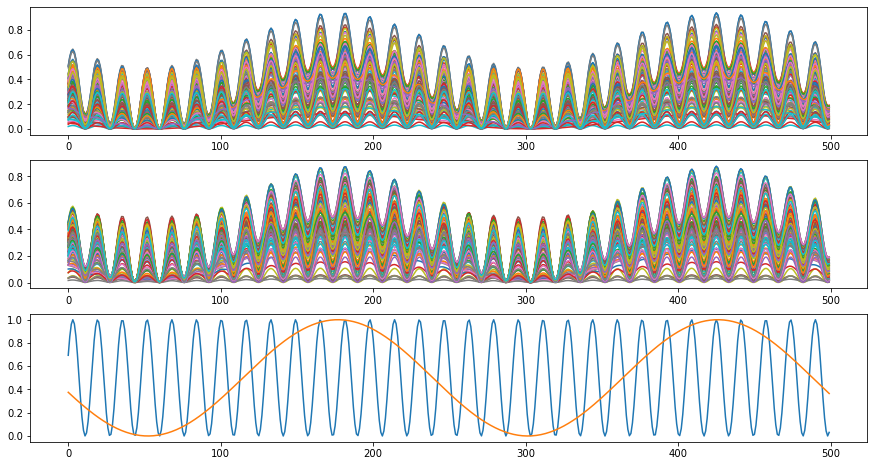

In [8]:
plt.figure(figsize=(15,8))
plt.subplot(311)
plt.plot(rates[0].numpy())
plt.subplot(312)
plt.plot(rates[1].numpy())

plt.subplot(313)
plt.plot(y_data[0].cpu().numpy());

In [9]:
prob = rates.to(device)*time_step*max_rate
mask = torch.rand((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data = torch.zeros((batch_size,n_steps,n_inputs), device=device, dtype=dtype)
x_data[mask<prob] = 1.0

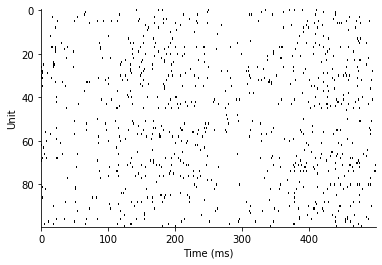

In [10]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

### Tunable time constants
Rather than, as previously, setting a global time constant for membranes and synapses, we'll give each neuron its own membrane tau, and each synapse its own decay tau. While there is room in principle for a more parsimonious account with these values constant across a particular population or connection class, it is easier for a start to just go with individual values.

Min/max values and the sigmoid method for keeping variables within bounds are taken from Li2020-ip.

In [11]:
tau_mem_min, tau_mem_max = 5e-3, 50e-3
tau_syn_min, tau_syn_max = 5e-3, 100e-3

tau_factor = lambda tau: float(np.exp(-time_step/tau))

alpha_lo, alpha_hi = tau_factor(tau_syn_min), tau_factor(tau_syn_max)
beta_lo,  beta_hi  = tau_factor(tau_mem_min), tau_factor(tau_mem_max)

def sigmoid_project(value, lo, hi, framework = torch):
    return lo + (hi-lo)/(1 + framework.exp(-value))

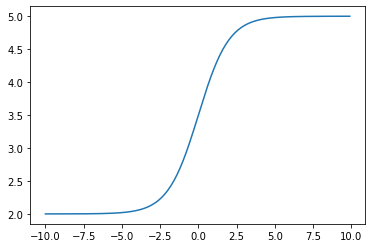

In [12]:
plt.plot(np.arange(-10,10,.1), sigmoid_project(np.arange(-10,10,.1), 2,5, np))

For simplicity, we'll apply time constant variability only to recurrent synapses as well as the hidden layer membranes, so we still need constant values for readout:

In [13]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha_0   = tau_factor(tau_syn)
beta_0    = tau_factor(tau_mem)

Spreading initial values in [-2,2] (unprojected) seems reasonable and does not leave much room uncovered.

In [14]:
def init_taus(lo = -2, hi = 2):
    '''
    Initialises alpha, beta for hidden layer recurrent synapses and membranes
    Note: Does not apply the non-linear limit projection.
    Parameters lo, hi are bounds on a uniform distribution in the pre-projection space.
    '''
    with torch.no_grad():
        # Recurrent synapses:
        alpha = torch.empty((n_hidden, n_hidden),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.uniform_(alpha, lo, hi)
        
        # Hidden membranes:
        beta = torch.empty((n_hidden),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.uniform_(beta, lo, hi)
    return alpha, beta

alpha, beta = init_taus()

We'll initialise weights scaled as if the membrane time scale hadn't changed:

In [15]:
weight_scale = 7*(1.0-beta_0) # this should give us some spikes to begin with

We'll skip the naive version without surrogate gradients, and dive right into the real thing with different forward and backward functions:

In [16]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient
#     scale = 10.0

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
#         grad = grad_input * torch.max(SurrGradSpike.scale*input + 1.0, torch.zeros_like(input))
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
spike_fn  = SurrGradSpike.apply

### Structure
To support Dale's law in this network, we'll have to explicitly enforce it at every step, otherwise the optimiser might try to mess with the weight signs. This means we need a readily enforceable template:

In [17]:
nested_signs = [[sign] * num for num,sign in zip(n_sub, sub_sign)]
flat_signs = [i for part in nested_signs for i in part]
w_signs = torch.tensor(flat_signs, device=device, dtype=dtype).diag()

# Normalise weights with:
# weights = torch.einsum('ab,bc->ac', w_signs, torch.abs(weights))

In addition, we'll need not only input weights, but also recurrent weights:

In [18]:
def init_weights():
    with torch.no_grad():
        w1 = torch.empty((n_inputs, n_hidden),  device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(n_inputs))

        w2 = torch.empty((n_hidden, n_outputs), device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(n_hidden))

        wr = torch.empty((n_hidden, n_hidden), device=device, dtype=dtype, requires_grad=True)
        torch.nn.init.normal_(wr, mean=0.0, std=weight_scale/np.sqrt(n_hidden))
    return w1, w2, wr
w1, w2, wr = init_weights()

Putting it all together:

In [19]:
def run_snn(inputs):

    # Compute the input currents
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    
    # Zero-initialise state variables
    syn_1 = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    syn_r = torch.zeros((batch_size,n_hidden,n_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    out = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    
    # Add Dale's Law signs to recurrent weights and add batch dimension
    rec_weights = torch.matmul(w_signs, torch.abs(wr)).unsqueeze(0)
    
    # Transform time constants and add batch dimension
    alpha_r = sigmoid_project(alpha, alpha_lo, alpha_hi).unsqueeze(0)
    beta_r = sigmoid_project(beta, beta_lo, beta_hi).unsqueeze(0)

    # Lists to collect states
    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(n_steps):
        # intermediates
        syn = syn_1 + torch.sum(syn_r, 1) # sum over presyn
        
        # integrate PSPs with spikes from previous time step
        syn_r = alpha_r*syn_r + out.unsqueeze(-1) * rec_weights # unsqueeze out to add postsyn dimension
        syn_1 = alpha_0*syn_1 + h1[:,t]
        
        # Mark spikes
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        rst[mthr > 0] = 1.0

        # Integrate membrane potential
        mem = beta_r*mem +syn -rst

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,n_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,n_outputs), device=device, dtype=dtype)
    out_rec = []
    for t in range(n_steps):
        new_flt = alpha_0*flt +h2[:,t]
        new_out = beta_0*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

To check things behave as they should, let's keep the previous implementation around, as well:

In [20]:
def run_snn_p3(inputs):
    
    # Compute the input currents, which are effectively the input weight matrix `w1`
    # masked by the input spikes `x_data`:
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    
    # Zero-initialise state variables
    syn = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    out = torch.zeros((batch_size,n_hidden), device=device, dtype=dtype)
    
    # Add Dale's Law signs to recurrent weights
    # Not to readouts though, that makes training unstable!
    rec_weights = torch.matmul(w_signs, torch.abs(wr))

    # Lists to collect states
    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(n_steps):
        rec_syn = torch.einsum("ab,bc->ac", out, rec_weights)
        
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        rst[mthr > 0] = 1.0

        new_syn = alpha_0*syn +h1[:,t] +rec_syn
        new_mem = beta_0*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,n_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,n_outputs), device=device, dtype=dtype)
    out_rec = []
    for t in range(n_steps):
        new_flt = alpha_0*flt +h2[:,t]
        new_out = beta_0*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [21]:
out_rec,other_recs = run_snn(x_data)
out_rec_3,other_recs_3 = run_snn_p3(x_data)
torch.allclose(out_rec,out_rec_3)

False

Define a helper function to visualise activity:

In [22]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5, ax=None):
    if type(ax) == type(None):
        _,ax = plt.subplots(*dim, sharey=True)
    ax = ax.flatten()
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        ax[i].plot(dat[i])
        ax[i].axis("off")
    return ax

<Figure size 600x400 with 0 Axes>

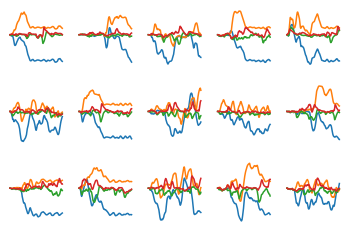

In [23]:
fig=plt.figure(dpi=100)
ax = plot_voltage_traces(out_rec)
plot_voltage_traces(out_rec_3, ax=ax);

There's no such thing as accuracy any more, but we can look at the loss:

In [24]:
loss_fn = torch.nn.MSELoss()
print("Mean squared error: %.3f" % loss_fn(out_rec, y_data))

Mean squared error: 307.312


Let's add a function to inspect the gradients:

In [25]:
from matplotlib.lines import Line2D
def get_grad_plotter(alpha = 0.1, top = 0.02):
    def plot_grads(named_parameters, ax):
        '''Plots the gradients flowing through different layers in the net during training.
        Can be used for checking for possible gradient vanishing / exploding problems.

        Usage: Plug this function in Trainer class after loss.backwards() as 
        "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
        ave_grads = []
        max_grads= []
        layers = []
        for n, p in named_parameters:
            if p.requires_grad:
                grad = p.grad.abs()
                ave_grads.append(grad.mean())
                max_grads.append(grad.max())
                layers.append(n)
        ax.bar(np.arange(len(max_grads))+.4, max_grads, alpha=alpha, width=.4, color="c")
        ax.bar(np.arange(len(max_grads)), ave_grads, alpha=alpha, width=.4, color="b")
        ax.xaxis.set_ticks(range(0,len(ave_grads), 1))
        ax.xaxis.set_ticklabels(layers, rotation="vertical")
        ax.set_ylim(top=top)
        ax.set_xlabel("Layers")
        ax.set_ylabel("Gradient")
        ax.grid(True)
        ax.legend([Line2D([0], [0], color="c", lw=4),
                   Line2D([0], [0], color="b", lw=4)], ['max-gradient', 'mean-gradient'])
        sns.despine(offset=4)
    return plot_grads

I have no idea whether this will train! Let's try.

Forward, backward, overhead: 0.196 s; 0.274 s; 0.008 s
Forward, backward, overhead: 0.183 s; 0.251 s; 0.019 s
Forward, backward, overhead: 0.186 s; 0.251 s; 0.020 s
Forward, backward, overhead: 0.193 s; 0.256 s; 0.020 s
Forward, backward, overhead: 0.190 s; 0.252 s; 0.020 s
Forward, backward, overhead: 0.197 s; 0.255 s; 0.019 s
Forward, backward, overhead: 0.195 s; 0.252 s; 0.020 s
Forward, backward, overhead: 0.198 s; 0.255 s; 0.020 s
Forward, backward, overhead: 0.188 s; 0.251 s; 0.020 s


<ipython-input-22-2b749f96f2ba>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _,ax = plt.subplots(*dim, sharey=True)


Forward, backward, overhead: 0.195 s; 0.253 s; 0.020 s


<ipython-input-30-48d32d9ad5b1>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(dpi=100)


Forward, backward, overhead: 0.203 s; 0.253 s; 0.020 s
Forward, backward, overhead: 0.198 s; 0.255 s; 0.020 s
Forward, backward, overhead: 0.194 s; 0.254 s; 0.020 s
Forward, backward, overhead: 0.198 s; 0.252 s; 0.020 s
Forward, backward, overhead: 0.199 s; 0.255 s; 0.020 s
Forward, backward, overhead: 0.206 s; 0.257 s; 0.028 s
Forward, backward, overhead: 0.200 s; 0.255 s; 0.020 s
Forward, backward, overhead: 0.196 s; 0.253 s; 0.020 s
Forward, backward, overhead: 0.223 s; 0.264 s; 0.020 s
Forward, backward, overhead: 0.233 s; 0.263 s; 0.020 s


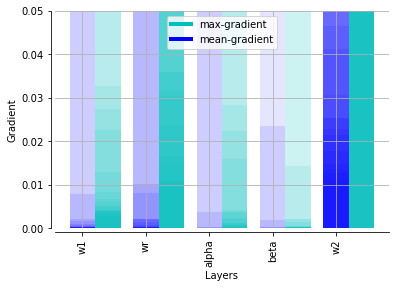

<Figure size 600x400 with 0 Axes>

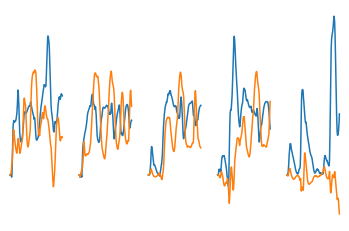

<Figure size 600x400 with 0 Axes>

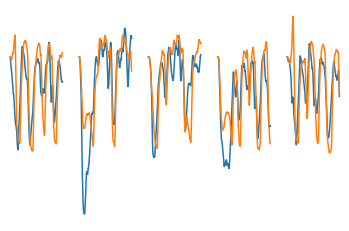

<Figure size 600x400 with 0 Axes>

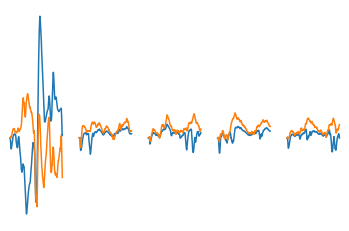

<Figure size 600x400 with 0 Axes>

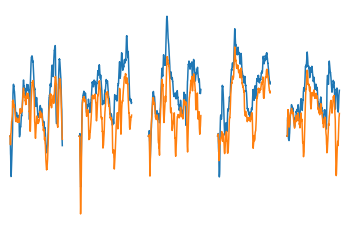

<Figure size 600x400 with 0 Axes>

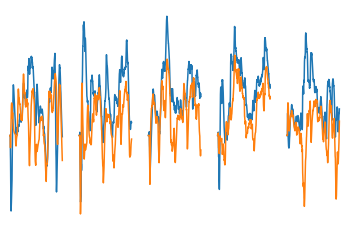

<Figure size 600x400 with 0 Axes>

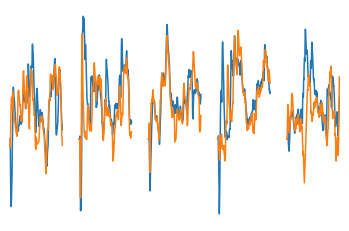

<Figure size 600x400 with 0 Axes>

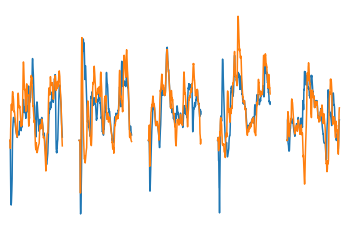

<Figure size 600x400 with 0 Axes>

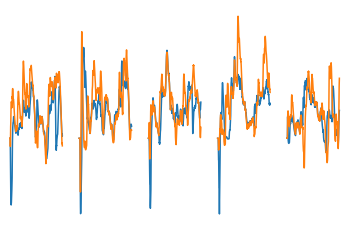

<Figure size 600x400 with 0 Axes>

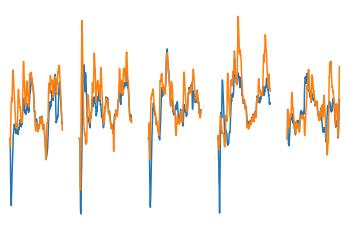

<Figure size 600x400 with 0 Axes>

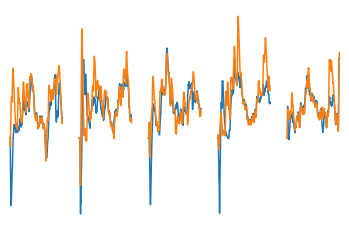

<Figure size 600x400 with 0 Axes>

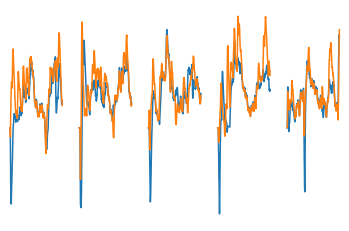

<Figure size 600x400 with 0 Axes>

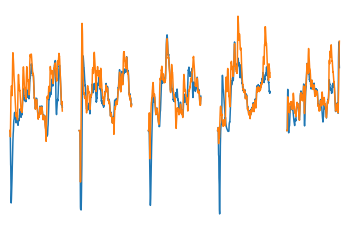

<Figure size 600x400 with 0 Axes>

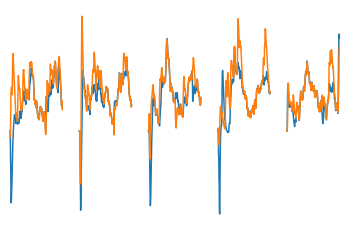

<Figure size 600x400 with 0 Axes>

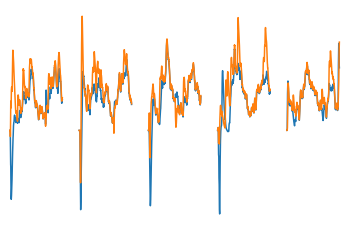

<Figure size 600x400 with 0 Axes>

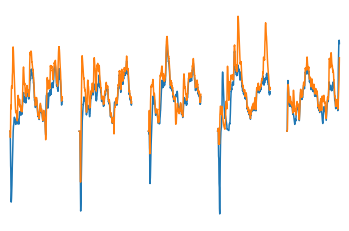

<Figure size 600x400 with 0 Axes>

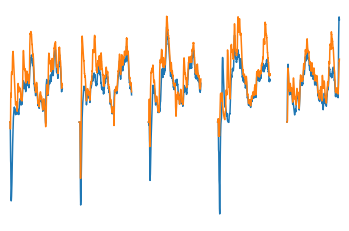

<Figure size 600x400 with 0 Axes>

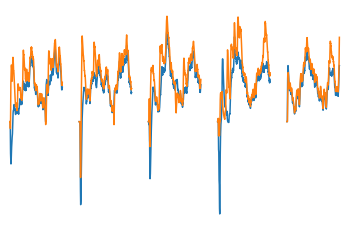

<Figure size 600x400 with 0 Axes>

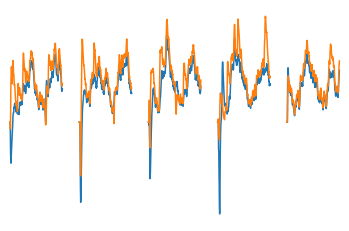

<Figure size 600x400 with 0 Axes>

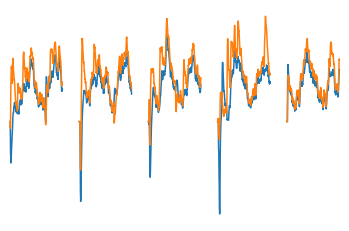

<Figure size 600x400 with 0 Axes>

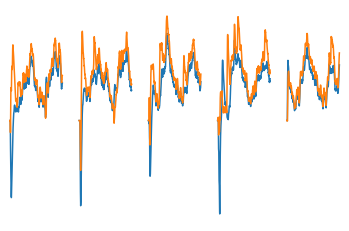

In [30]:
w1,w2,wr = init_weights()
alpha, beta = init_taus()

params = [w1,wr,alpha,beta,w2] # The parameters we want to optimize
named_params = [(n,p) for n,p in zip(['w1','wr','alpha','beta','w2'], params)]
optimizer = torch.optim.Adam(params, lr=2e-3, betas=(0.9,0.999)) # The optimizer we are going to use

epochs, reporting_interval = 200, 20
t_forward = t_backward = overhead = 0
tic = time.perf_counter()

ax = plt.figure().subplots()
plot_grad = get_grad_plotter(top=.05)

# The optimization loop
loss_hist = []
for e in range(epochs):
    # run the network and get output
    overhead += time.perf_counter() - tic
    tic = time.perf_counter()
    
    output,_ = run_snn(x_data)
    
    toc = time.perf_counter()
    t_forward += toc-tic
    
    # compute the loss
    loss_val = loss_fn(output, y_data)

    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()
    
    tic = time.perf_counter()
    t_backward += tic-toc
    
    # store loss value
    loss_hist.append(loss_val.item())
    
    if e%reporting_interval == 0:
        plot_grad(named_params, ax)
        fig=plt.figure(dpi=100)
        plot_voltage_traces(output,dim=(1,5))
        if e > 0:
            t_forward /= reporting_interval
            t_backward /= reporting_interval
            overhead /= reporting_interval
        print("Forward, backward, overhead: %0.3f s; %0.3f s; %0.3f s" % (t_forward, t_backward, overhead))
        t_forward = t_backward = overhead = 0

0.13298708200454712


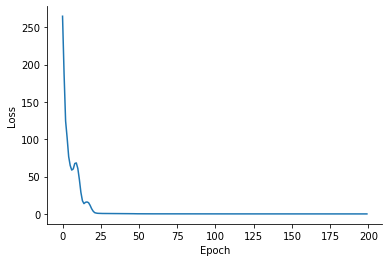

In [31]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()
print(loss_hist[-1])

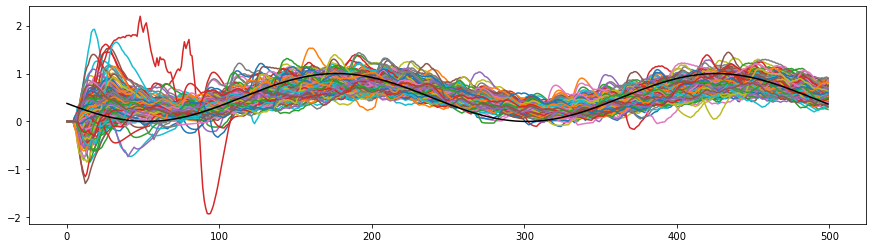

In [32]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,1].detach().cpu().numpy().T);
plt.plot(y_data[0,:,1].cpu().numpy(), color='black')

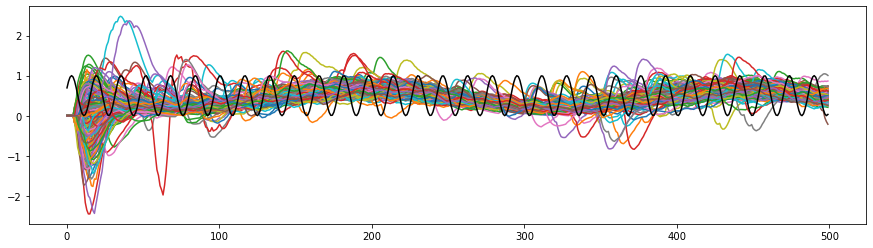

In [33]:
plt.figure(figsize=(15,4))
plt.plot(output[:,:,0].detach().cpu().numpy().T);
plt.plot(y_data[0,:,0].cpu().numpy(), color='black')

Hah, so time scale adaptation does something, but the problem remains very difficult, to nobody's particular surprise. We'll see how that changes as I add a deeper structure, as well as plastic weights.